In [1]:
import sys;
sys.path.insert(0, '..')

## Chapter 12 Code Snippets and Listings

### Source-level compatibility between Hume and Qiskit (12.2.2)

In order to have source-level compatibility between Hume and Qiskit, we have enhanced Qiskit's `QuantumCircuit` class with the same functionality.
We add the methods defined below in the file ./hume/qiskit/__init__.py in the book's companion repository.

Note that you will need to install Qiskit in order to use Qiskit circuits.

Let's define and run a circuit using Hume:

In [2]:
from math import pi

def encode_value(n, v):
    q = hume.QuantumRegister(n)
    qc = hume.QuantumCircuit(q)
    
    for j in range(n):
        qc.h(q[j])
    
    for j in range(n):
        qc.p(2 * pi / 2 ** (n - j) * v, q[j])
    
    qc.iqft(q)
    
    return qc

In [3]:
import hume

In [4]:
hume.QuantumRegister = hume.simulator.circuit.QuantumRegister
hume.QuantumCircuit = hume.simulator.circuit.QuantumCircuit

qc = encode_value(3, 4.7)
print(type(qc))

<class 'hume.simulator.circuit.QuantumCircuit'>


In [5]:
from util import print_state_table

state_hume = qc.run()
print_state_table(state_hume)


Outcome  Binary  Amplitude           Magnitude  Direction  Amplitude Bar             Probability
------------------------------------------------------------------------------------------------
0        000     0.0986 + i0.0364    0.1051       20.26°   ██                        0.011 
1        001     0.0748 + i0.0691    0.1018       42.73°   ██                        0.0104
2        010     0.0485 + i0.1053    0.1159       65.27°   ██                        0.0134
3        011     0.0064 + i0.1632    0.1633       87.75°   ███                       0.0267
4        100    -0.1289 + i0.3495    0.3726      110.24°   ████████                  0.1388
5        101     0.5840 - i0.6318    0.8604      -47.75°   ████████████████████      0.7403
6        110     0.1880 - i0.0866    0.207       -24.27°   ████                      0.0428
7        111     0.1287 - i0.0051    0.1288       -2.73°   ███                       0.0166



Now, we can run the same circuit using Qiskit:

In [6]:
import qiskit
import hume.qiskit
hume.QuantumRegister = qiskit.QuantumRegister
hume.QuantumCircuit = qiskit.QuantumCircuit

qc = encode_value(3, 4.7)

print(type(qc))

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


In [7]:
state_qiskit = qc.run()
print_state_table(state_qiskit)


Outcome  Binary  Amplitude           Magnitude  Direction  Amplitude Bar             Probability
------------------------------------------------------------------------------------------------
0        000     0.0986 + i0.0364    0.1051       20.26°   ██                        0.011 
1        001     0.0748 + i0.0691    0.1018       42.73°   ██                        0.0104
2        010     0.0485 + i0.1053    0.1159       65.27°   ██                        0.0134
3        011     0.0064 + i0.1632    0.1633       87.75°   ███                       0.0267
4        100    -0.1289 + i0.3495    0.3726      110.24°   ████████                  0.1388
5        101     0.5840 - i0.6318    0.8604      -47.75°   ████████████████████      0.7403
6        110     0.1880 - i0.0866    0.207       -24.27°   ████                      0.0428
7        111     0.1287 - i0.0051    0.1288       -2.73°   ███                       0.0166



Check that the results match:

In [8]:
from util import all_close
assert all_close(state_hume, state_qiskit)

In [9]:
hume.QuantumRegister = hume.simulator.circuit.QuantumRegister
hume.QuantumCircuit = hume.simulator.circuit.QuantumCircuit

### Running on real quantum hardware (12.2.3)

The code for this section can be found in this [notebook](/ibmq/ibmq_experiments_sampler.ipynb).

### Another look at single-qubit gates and the butterfly pattern (12.3.1)

Given a quantum system with $n \ge 1$ qubits, a target qubit $t$, where $1 \le t \le n$, and a single-qubit gate represented by a $2 \times 2$ (unitary) matrix

$$U = \begin{bmatrix}a & b \\ c & d \end{bmatrix}$$

the effect of the gate on the state of the quantum system can be described as follows.
First, we identify the pairs of amplitudes to be recombined based on the target qubit.
In the code below, we create a two-row matrix with the amplitudes of each pair.


In [10]:
import numpy as np

def get_two_row_matrix_from_state(state, t):
    stride = 2**t

    chunks = np.array_split(state, int(len(state)/stride))
    evens = np.concatenate(chunks[0::2])
    odds = np.concatenate(chunks[1::2])

    return np.stack((evens, odds))

If we denote this matrix by $A_t$, then the effect of the gate on the amplitudes can be described by

$$U A_t.$$

Then, we put the amplitudes back in the original order:

In [11]:
def get_state_from_two_row_matrix(matrix_state, t):
    chunk_size = int(matrix_state.shape[1] / 2**t)

    chunks_0 = np.array_split(matrix_state[0], chunk_size)
    chunks_1 = np.array_split(matrix_state[1], chunk_size)
    return np.hstack((chunks_0, chunks_1)).flatten()

For a unitary matrix $U$ of size $2^m \times 2^m$ that is applied to $m > 0$ target qubits, the conversion functions are:

In [12]:
def get_matrix_state(state, t, m):
    n = int(np.log2(len(state)))
    o_dim = 2**(n-m)
    u_dim = 2**m
    stride = 2**t

    matrix_state = np.zeros((u_dim, o_dim), dtype=complex)

    for remainder in range(stride):
        for idx in range(u_dim):
            matrix_state[idx, remainder::stride] = state[remainder + idx * stride::u_dim*stride]

    return matrix_state

def get_state_from_matrix(matrix_state, t, m):
    n = int(np.log2(matrix_state.shape[0] * matrix_state.shape[1]))

    u_dim = 2**m
    stride = 2**t

    state = np.zeros(2**n, dtype=complex)

    for remainder in range(stride):
        for idx in range(u_dim):
            state[idx * stride + remainder::u_dim*stride] = matrix_state[idx, remainder::stride]

    return state

Let's use these functions to simulate applying a unitary transformation (represented by a $4 \times 4$ unitary matrix) of a state a randomly generated state with $n = 3$ qubits:

In [13]:
from hume.utils.common import print_state_table, generate_state
from hume.utils.matrix import rvs

n = 3
t = 1
m = 2

state = generate_state(n)

U = rvs(2**m)

matrix = get_matrix_state(state.copy(), t, m)
s1 = get_state_from_matrix(U@matrix, t, m)

In [14]:
print_state_table(s1)


Outcome  Binary  Amplitude           Magnitude  Direction  Amplitude Bar             Probability
------------------------------------------------------------------------------------------------
0        000     0.3846 + i0.2189    0.4425       29.65°   ██████████                0.1958
1        001    -0.1127 - i0.0520    0.1241     -155.77°   ██                        0.0154
2        010    -0.0897 - i0.1978    0.2171     -114.61°   █████                     0.0472
3        011    -0.0429 - i0.0036    0.0431     -175.80°   █                         0.0019
4        100     0.0195 + i0.0653    0.0682       73.37°   █                         0.0046
5        101    -0.6623 - i0.3130    0.7325     -154.30°   █████████████████         0.5366
6        110    -0.1506 - i0.3509    0.3819     -113.77°   █████████                 0.1458
7        111    -0.1786 + i0.1443    0.2296      141.60°   █████                     0.0527



Now, let's apply the same transformation to the same state using our `QuantumCircuit` class:

In [15]:
from hume.simulator.circuit import QuantumRegister
from hume.simulator.circuit import QuantumCircuit

q = QuantumRegister(3)
qc = QuantumCircuit(q)
qc.initialize(state.copy())
qc.unitary(U, t)

s2 = qc.run()

In [16]:
print_state_table(s2)


Outcome  Binary  Amplitude           Magnitude  Direction  Amplitude Bar             Probability
------------------------------------------------------------------------------------------------
0        000     0.3846 + i0.2189    0.4425       29.65°   ██████████                0.1958
1        001    -0.1127 - i0.0520    0.1241     -155.77°   ██                        0.0154
2        010    -0.0897 - i0.1978    0.2171     -114.61°   █████                     0.0472
3        011    -0.0429 - i0.0036    0.0431     -175.80°   █                         0.0019
4        100     0.0195 + i0.0653    0.0682       73.37°   █                         0.0046
5        101    -0.6623 - i0.3130    0.7325     -154.30°   █████████████████         0.5366
6        110    -0.1506 - i0.3509    0.3819     -113.77°   █████████                 0.1458
7        111    -0.1786 + i0.1443    0.2296      141.60°   █████                     0.0527



Check that they match:

In [17]:
assert all_close(s1, s2)

### Quantum states as an image (12.4)

The function defined below creates the pixel state visualization shown in the chapter:

In [18]:
from hume.utils.common import complex_to_rgb

from PIL import Image

def state_to_pixels(s, cols=1, neg=False):
    global counter
    counter = 0
    rows = int(len(s) / cols)


    img = Image.new('RGBA', (cols, rows))
    pixels = img.load()

    idx =  list(range(int(rows/2), rows)) + list(range(int(rows/2)))
    for l in range(cols):
        for k in range(rows):
            c = s[idx[k]*cols + l] if neg else s[k*cols + l]
            rgb = complex_to_rgb(c, True)
            intensity = int(abs(c)*255)
            if intensity > 0:
                pixels[l, rows-1-k if neg else k] = (rgb[0], rgb[1], rgb[2], intensity)  # set the colour accordingly
            else:
                pixels[l, rows-1-k if neg else k] = (0, 0, 0, 10)

    factor_c = 15
    factor_r = 15
    img = img.resize((factor_c*cols, factor_r*rows), resample=0)

    return img    

Let's look at some example 3-qubit states:

In [19]:
n = 2
m = 1

N = 2**n
M = 2**m 

In [20]:
from hume.simulator.core import init_state
state = init_state(n+m)  

The initial state as an array of pixels:

In [21]:
display(state_to_pixels(state, N*M))

The initial state as an array of pixels, partitioned at qubit 2:

In [22]:
display(state_to_pixels(state, N))

Let's look at a random state:

In [23]:
state = generate_state(n+m)  

In [24]:
display(state_to_pixels(state, N*M))

In [25]:
display(state_to_pixels(state, N))

Example with 4-qubit state:

In [26]:
n = 2
m = 2

N = 2**n
M = 2**m

In [27]:
state = generate_state(n+m)

In [28]:
display(state_to_pixels(state, N*M))

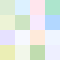

In [29]:
display(state_to_pixels(state, N))

### Visualizing quantum state evolution (12.4.1)

Following is code to visualize several steps of a circuit that encodes the given polynomial in a quantum state:

In [30]:
def combine_images(imgs):
    widths, heights = zip(*(im.size for im in imgs))
    
    space = 10

    total_width = sum(widths) + 10*(len(imgs) - 1)
    max_height = max(heights) + 10*(len(imgs) - 1)

    img = Image.new('RGB', (total_width, max_height), 'white')

    x = 0
    for im in imgs:
        img.paste(im, (x, 0))
        x += im.size[0] + space

    return img

<class 'hume.simulator.circuit.QuantumCircuit'>


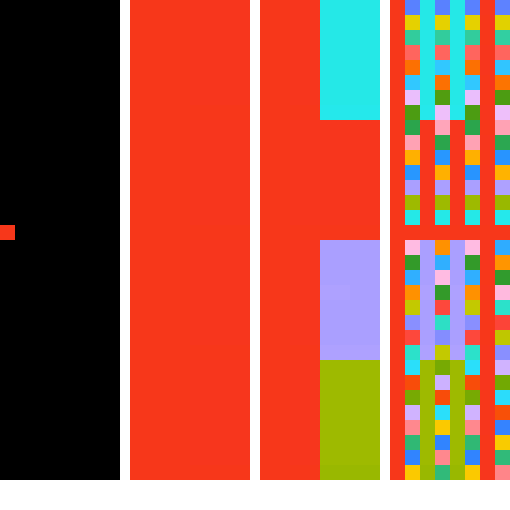

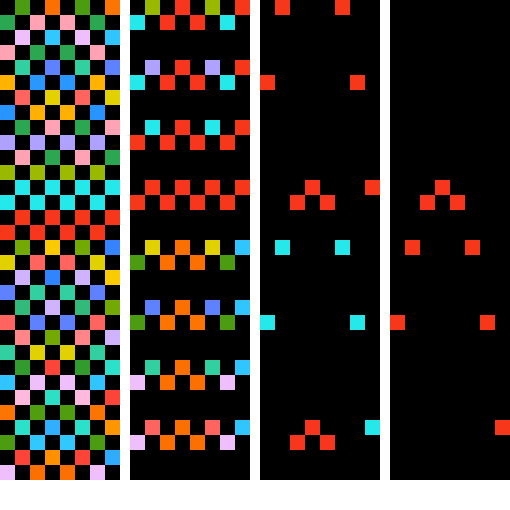

In [31]:
from hume.algos.function_encoding import build_polynomial_circuit

n = 3
N = 2**n
m = 5

terms = [(8, [2]), (8, [1]), (5, [0]), (-16, [1, 2]), (-8, [0, 2]), (-4, [0, 1]), (-6, [])]

qc = build_polynomial_circuit(n, m, terms)
print(type(qc))

t = len(terms)
assert len(qc.transformations) == n + (t + 2)*m + m*(m - 1 )/2

screens = []
for idx, (tr, state) in enumerate(qc.run_and_yield()):
    if idx in [0, 11, 16, 36, 45, 51, 57, 58]:
        screens.append(state_to_pixels(state, N, True))

display(combine_images(screens[:len(screens)//2]))
display(combine_images(screens[len(screens)//2:]))

### Encoding polynomials with non-integer coefficients (12.5.1)

Even though we have been using polynomial functions with integer coefficients in our optimization examples, the polynomial encoding method can handle non-integer coefficients.
Instead of a single value, each input will have a corresponding discrete-sinc distribution encoding its corresponding output.
Let's look at the concrete example of the function

$$f(k) = 0.4 k^2 - 2.3$$

defined for $0 \le k < 4$.

The code below encodes this function in a quantum state:

In [32]:
from hume.algos.function_encoding import build_polynomial_circuit

n_key = 2
n_value = 4
neg = True

coeffs = [(-2.3, [])] + [(0.4*2**(j+k), ([j, k] if j != k else [j]))  for j in range(n_key) for k in range(n_key)] # squares

function = build_polynomial_circuit(n_key, n_value, coeffs)
state = function.run()

In [33]:
from util import grid_state

grid_state(state, n_key, True, False)



╒═══════════╤══════════╤══════════╤══════════╤══════════╕
│           │ 0 = 00   │ 1 = 01   │ 2 = 10   │ 3 = 11   │
╞═══════════╪══════════╪══════════╪══════════╪══════════╡
│ 7 = 0111  │          │          │          │          │
├───────────┼──────────┼──────────┼──────────┼──────────┤
│ 6 = 0110  │          │          │          │          │
├───────────┼──────────┼──────────┼──────────┼──────────┤
│ 5 = 0101  │          │          │          │          │
├───────────┼──────────┼──────────┼──────────┼──────────┤
│ 4 = 0100  │          │          │          │          │
├───────────┼──────────┼──────────┼──────────┼──────────┤
│ 3 = 0011  │          │          │          │          │
├───────────┼──────────┼──────────┼──────────┼──────────┤
│ 2 = 0010  │          │          │          │          │
├───────────┼──────────┼──────────┼──────────┼──────────┤
│ 1 = 0001  │          │          │          │          │
├───────────┼──────────┼──────────┼──────────┼──────────┤
│ 0 = 0000  